In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings
import matplotlib.pyplot as plt
import copy, time, glob, os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from helpers import *
from utilities import *
from model import *
from train import train_all_single_policies
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)
models_path = './models/' 

C:\Users\sshi\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load raw data

In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(3)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Get some suplementary data

In [3]:
# play id to play roles/positions
id_role = id_position(events_df)
check_game_roles_duplicates(id_role)

# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order
# ddentify defending and offending runs (this is included in process_moments)
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

# home and visitor ids
homeid = events_df.loc[0].home['teamid']
awayid = events_df.loc[0].visitor['teamid']

#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [11]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
# use_event = [1, 2, 4, 6, 7]
# discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
# events = filter_event_type(events_df, discard_event)
events = events_df.copy()
# print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
subsample_factor = 2
single_game, single_game_balls = get_game_data_ra(events, court_index, game_id, 
                                                  event_threshold=10, subsample_factor=subsample_factor)
print('Final number of events:', len(single_game))

# get player velocity
fs_base = 1./25 # 1/25 sec/frame   or  25 frames/sec
fs = fs_base * subsample_factor if subsample_factor != 0 else fs_base
single_game = [get_velocity(i, fs, mode=1) for i in single_game]
n_events = len(single_game)

# get basketball velocity
single_game_balls = [np.concatenate([i[:-1, :], get_velocity(i, fs, mode=0)], axis=1) for i in single_game_balls]

0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72

355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ======

145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ======

196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ======

210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ======

430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ==========
456 ==========
457 ==========
458 ==========
459 ==========
460 ==========
461 ==========
462 ==========
463 ==========
464 ==========
465 ==========
466 ==========
467 ==========
468 ==========
469 ==========
470 ==========
471 ==========
472 ==========
473 ==========
474 ==========
475 ==========
476 ==========
477 ==========
478 ==========
479 ==========
480 ==========
481 ==========
482 ==========
483 ==========
484 ==========
485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ======

275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ======

380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ======

92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159

217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ======

389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ======

27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ===

38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ========

314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ======

75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 =

90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 =

35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
Warning!: Ball is not present.
46 ==========
Warning!: Ball is not present.
47 ==========
Warning!: Ball is not present.
48 ==========
Warning!: Ball is not present.
49 ==========
Warning!: Ball is not present.
50 ==========
Warning!: Ball is not present.
51 ==========
Warning!: Ball is not present.
52 ==========
Warning!: Ball is not present.
53 ==========
Warning!: Ball is not present.
54 ==========
Warning!: Ball is not present.
55 ==========
Warning!: Ball is not present.
56 ==========
Warning!: Ball is not present.
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 =========

223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ======

218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ======

389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 =====

592 ==========
593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
600 ==========
601 ==========
602 ==========
603 ==========
604 ==========
605 ==========
606 ==========
607 ==========
608 ==========
609 ==========
610 ==========
611 ==========
612 ==========
613 ==========
614 ==========
615 ==========
616 ==========
617 ==========
618 ==========
619 ==========
620 ==========
621 ==========
622 ==========
623 ==========
624 ==========
625 ==========
626 ==========
627 ==========
628 ==========
629 ==========
630 ==========
631 ==========
632 ==========
633 ==========
634 ==========
635 ==========
636 ==========
637 ==========
638 ==========
639 ==========
640 ==========
641 ==========
642 ==========
643 ==========
644 ==========
645 ==========
646 ==========
647 ==========
648 ==========
649 ==========
650 ==========
651 ==========
652 ==========
653 ==========
654 ==========
655 ==========
656 ==========
657 ==========
658 ======

555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ==========
584 ==========
585 ==========
586 ==========
587 ==========
588 ==========
589 ==========
590 ==========
591 ==========
592 ==========
593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========

22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ===

206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ======

259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ======

367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ======

98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ========

134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ======

126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ======

301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ======

384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========


395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ==========
456 ==========
457 ==========
458 ==========
459 ==========
460 ==========
461 ======

432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ==========
456 ==========
457 ==========
458 ==========
459 ==========
460 ==========
461 ==========
462 ==========
463 ==========
464 ==========
465 ==========
466 ==========
467 ==========
468 ==========
469 ==========
470 ==========
471 ==========
472 ==========
473 ==========
474 ==========
475 ==========
476 ==========
477 ==========
478 ==========
479 ==========
480 ==========
481 ==========
482 ==========
483 ==========
484 ==========
485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 =====

286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ======

272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==

41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 =====

96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========

606 ==========
607 ==========
608 ==========
609 ==========
610 ==========
611 ==========
612 ==========
613 ==========
614 ==========
615 ==========
616 ==========
617 ==========
618 ==========
619 ==========
620 ==========
621 ==========
622 ==========
623 ==========
624 ==========
625 ==========
626 ==========
627 ==========
628 ==========
629 ==========
630 ==========
631 ==========
632 ==========
633 ==========
634 ==========
635 ==========
636 ==========
637 ==========
638 ==========
639 ==========
640 ==========
641 ==========
642 ==========
643 ==========
644 ==========
645 ==========
646 ==========
647 ==========
648 ==========
649 ==========
650 ==========
651 ==========
652 ==========
653 ==========
654 ==========
655 ==========
656 ==========
657 ==========
658 ==========
659 ==========
660 ==========
661 ==========
662 ==========
663 ==========
664 ==========
665 ==========
666 ==========
667 ==========
668 ==========
669 ==========
670 ==========
671 ==========
672 ======

64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
1

266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ======

634 ==========
635 ==========
636 ==========
637 ==========
638 ==========
639 ==========
640 ==========
641 ==========
642 ==========
643 ==========
644 ==========
645 ==========
646 ==========
647 ==========
648 ==========
649 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========


351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ======

637 ==========
638 ==========
639 ==========
640 ==========
641 ==========
642 ==========
643 ==========
644 ==========
645 ==========
646 ==========
647 ==========
648 ==========
649 ==========
650 ==========
651 ==========
652 ==========
653 ==========
654 ==========
655 ==========
656 ==========
657 ==========
658 ==========
659 ==========
660 ==========
661 ==========
662 ==========
663 ==========
664 ==========
665 ==========
666 ==========
667 ==========
668 ==========
669 ==========
670 ==========
671 ==========
672 ==========
673 ==========
674 ==========
675 ==========
676 ==========
677 ==========
678 ==========
679 ==========
680 ==========
681 ==========
682 ==========
683 ==========
684 ==========
685 ==========
686 ==========
687 ==========
688 ==========
689 ==========
690 ==========
691 ==========
692 ==========
693 ==========
694 ==========
695 ==========
696 ==========
697 ==========
698 ==========
699 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 =

289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ======

477 ==========
478 ==========
479 ==========
480 ==========
481 ==========
482 ==========
483 ==========
484 ==========
485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ======

621 ==========
622 ==========
623 ==========
624 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 =========

100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ======

716 ==========
717 ==========
718 ==========
719 ==========
720 ==========
721 ==========
722 ==========
723 ==========
724 ==========
725 ==========
726 ==========
727 ==========
728 ==========
729 ==========
730 ==========
731 ==========
732 ==========
733 ==========
734 ==========
735 ==========
736 ==========
737 ==========
738 ==========
739 ==========
740 ==========
741 ==========
742 ==========
743 ==========
744 ==========
745 ==========
746 ==========
747 ==========
748 ==========
749 ==========
750 ==========
751 ==========
752 ==========
753 ==========
754 ==========
755 ==========
756 ==========
757 ==========
758 ==========
759 ==========
760 ==========
761 ==========
762 ==========
763 ==========
764 ==========
765 ==========
766 ==========
767 ==========
768 ==========
769 ==========
770 ==========
771 ==========
772 ==========
773 ==========
774 ==========
775 ==========
776 ==========
777 ==========
778 ==========
779 ==========
780 ==========
781 ==========
782 ======

63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
13

238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ======

347 ==========
348 ==========
349 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========

335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ======

117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ======

330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ======

517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ======

408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ==========
456 ==========
457 ==========
458 ==========
459 ==========
460 ==========
461 ==========
462 ==========
463 ==========
464 ==========
465 ==========
466 ==========
467 ==========
468 ==========
469 ==========
470 ==========
471 ==========
472 ==========
473 ==========
474 ======

226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ======

568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ==========
584 ==========
585 ==========
586 ==========
587 ==========
588 ==========
589 ==========
590 ==========
591 ==========
592 ==========
593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
600 ==========
601 ==========
602 ==========
603 ==========
604 ==========
605 ==========
606 ==========
607 ==========
608 ==========
609 ==========
610 ==========
611 ==========
612 ==========
613 ==========
614 ==========
615 ==========
616 ==========
617 ==========
618 ==========
619 ==========
620 ==========
621 ==========
622 ==========
623 ==========
624 ==========
625 ==========
626 ==========
627 ==========
628 ==========
629 ==========
630 ==========
631 ==========
632 ==========
633 ==========
634 ======

150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ======

334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ======

7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ======

351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==

271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ======

382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ======

251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ======

249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ======

293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ======

447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ==========
456 ==========
457 ==========
458 ==========
459 ==========
460 ==========
461 ==========
462 ==========
463 ==========
464 ==========
465 ==========
466 ==========
467 ==========
468 ==========
469 ==========
470 ==========
471 ==========
472 ==========
473 ==========
474 ==========
475 ==========
476 ==========
477 ==========
478 ==========
479 ==========
480 ==========
481 ==========
482 ==========
483 ==========
484 ==========
485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ======

434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ==========
453 ==========
454 ==========
455 ==========
456 ==========
457 ==========
458 ==========
459 ==========
460 ==========
461 ==========
462 ==========
463 ==========
464 ==========
465 ==========
466 ==========
467 ==========
468 ==========
469 ==========
470 ==========
471 ==========
472 ==========
473 ==========
474 ==========
475 ==========
476 ==========
477 ==========
478 ==========
479 ==========
480 ==========
481 ==========
482 ==========
483 ==========
484 ==========
485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ======

638 ==========
639 ==========
640 ==========
641 ==========
642 ==========
643 ==========
644 ==========
645 ==========
646 ==========
647 ==========
648 ==========
649 ==========
650 ==========
651 ==========
652 ==========
653 ==========
654 ==========
655 ==========
656 ==========
657 ==========
658 ==========
659 ==========
660 ==========
661 ==========
662 ==========
663 ==========
664 ==========
665 ==========
666 ==========
667 ==========
668 ==========
669 ==========
670 ==========
671 ==========
672 ==========
673 ==========
674 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ====

201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ======

508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========

301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ======

292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ======

336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ======

82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
Warning!: There are less than 10 players! (skip)
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 =====

376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ======

176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ======

368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ======

78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
14

116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ======

77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==

237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ======

386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ==========
445 ==========
446 ==========
447 ==========
448 ==========
449 ==========
450 ==========
451 ==========
452 ======

194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ======

123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ======

195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ======

373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ======

459 ==========
460 ==========
461 ==========
462 ==========
463 ==========
464 ==========
465 ==========
466 ==========
467 ==========
468 ==========
469 ==========
470 ==========
471 ==========
472 ==========
473 ==========
474 ==========
475 ==========
476 ==========
477 ==========
478 ==========
479 ==========
480 ==========
481 ==========
482 ==========
483 ==========
484 ==========
485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ======

507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ======

10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ===

671 ==========
672 ==========
673 ==========
674 ==========
675 ==========
676 ==========
677 ==========
678 ==========
679 ==========
680 ==========
681 ==========
682 ==========
683 ==========
684 ==========
685 ==========
686 ==========
687 ==========
688 ==========
689 ==========
690 ==========
691 ==========
692 ==========
693 ==========
694 ==========
695 ==========
696 ==========
697 ==========
698 ==========
699 ==========
700 ==========
701 ==========
702 ==========
703 ==========
704 ==========
705 ==========
706 ==========
707 ==========
708 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ===

322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ======

339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ======

623 ==========
624 ==========
625 ==========
626 ==========
627 ==========
628 ==========
629 ==========
630 ==========
631 ==========
632 ==========
633 ==========
634 ==========
635 ==========
636 ==========
637 ==========
638 ==========
639 ==========
640 ==========
641 ==========
642 ==========
643 ==========
644 ==========
645 ==========
646 ==========
647 ==========
648 ==========
649 ==========
650 ==========
651 ==========
652 ==========
653 ==========
654 ==========
655 ==========
656 ==========
657 ==========
658 ==========
659 ==========
660 ==========
661 ==========
662 ==========
663 ==========
664 ==========
665 ==========
666 ==========
667 ==========
668 ==========
669 ==========
670 ==========
671 ==========
672 ==========
673 ==========
674 ==========
675 ==========
676 ==========
677 ==========
678 ==========
679 ==========
680 ==========
681 ==========
682 ==========
683 ==========
684 ==========
685 ==========
686 ==========
687 ==========
688 ==========
689 ======

118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ======

242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ==========
262 ==========
263 ==========
264 ==========
265 ==========
266 ==========
267 ==========
268 ==========
269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ======

493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ======

559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ==========
584 ==========
585 ==========
586 ==========
587 ==========
588 ==========
589 ==========
590 ==========
591 ==========
592 ==========
593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
600 ==========
601 ==========
602 ==========
603 ==========
604 ==========
605 ==========
606 ==========
607 ==========
608 ==========
609 ==========
610 ==========
611 ==========
612 ==========
613 ==========
614 ==========
615 ==========
616 ==========
617 ==========
618 ==========
619 ==========
620 ==========
621 ==========
622 ==========
623 ==========
624 ==========
625 ======

570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ==========
584 ==========
585 ==========
586 ==========
587 ==========
588 ==========
589 ==========
590 ==========
591 ==========
592 ==========
593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
600 ==========
601 ==========
602 ==========
603 ==========
604 ==========
605 ==========
606 ==========
607 ==========
608 ==========
609 ==========
610 ==========
611 ==========
612 ==========
613 ==========
614 ==========
615 ==========
616 ==========
617 ==========
618 ==========
619 ==========
620 ==========
621 ==========
622 ==========
623 ==========
624 ==========
625 ==========
626 ==========
627 ==========
628 ==========
629 ==========
630 ==========
631 ==========
632 ==========
633 ==========
634 ==========
635 ==========
636 ======

183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ======

148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ======

650 ==========
651 ==========
652 ==========
653 ==========
654 ==========
655 ==========
656 ==========
657 ==========
658 ==========
659 ==========
660 ==========
661 ==========
662 ==========
663 ==========
664 ==========
665 ==========
666 ==========
667 ==========
668 ==========
669 ==========
670 ==========
671 ==========
672 ==========
673 ==========
674 ==========
675 ==========
676 ==========
677 ==========
678 ==========
679 ==========
680 ==========
681 ==========
682 ==========
683 ==========
684 ==========
685 ==========
686 ==========
687 ==========
688 ==========
689 ==========
690 ==========
691 ==========
692 ==========
693 ==========
694 ==========
695 ==========
696 ==========
697 ==========
698 ==========
699 ==========
700 ==========
701 ==========
702 ==========
703 ==========
704 ==========
705 ==========
706 ==========
707 ==========
708 ==========
709 ==========
710 ==========
711 ==========
712 ==========
713 ==========
714 ==========
715 ==========
716 ======

22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ===

356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ======

286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ======

280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ======

355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ======

293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ======

103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ==========
139 ==========
140 ==========
141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ======

318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ======

503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ======

689 ==========
690 ==========
691 ==========
692 ==========
693 ==========
694 ==========
695 ==========
696 ==========
697 ==========
698 ==========
699 ==========
700 ==========
701 ==========
702 ==========
703 ==========
704 ==========
705 ==========
706 ==========
707 ==========
708 ==========
709 ==========
710 ==========
711 ==========
712 ==========
713 ==========
714 ==========
715 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 

378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ==========
398 ==========
399 ==========
400 ==========
401 ==========
402 ==========
403 ==========
404 ==========
405 ==========
406 ==========
407 ==========
408 ==========
409 ==========
410 ==========
411 ==========
412 ==========
413 ==========
414 ==========
415 ==========
416 ==========
417 ==========
418 ==========
419 ==========
420 ==========
421 ==========
422 ==========
423 ==========
424 ==========
425 ==========
426 ==========
427 ==========
428 ==========
429 ==========
430 ==========
431 ==========
432 ==========
433 ==========
434 ==========
435 ==========
436 ==========
437 ==========
438 ==========
439 ==========
440 ==========
441 ==========
442 ==========
443 ==========
444 ======

46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ==========
65 ==========
66 ==========
67 ==========
68 ==========
69 ==========
70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 

141 ==========
142 ==========
143 ==========
144 ==========
145 ==========
146 ==========
147 ==========
148 ==========
149 ==========
150 ==========
151 ==========
152 ==========
153 ==========
154 ==========
155 ==========
156 ==========
157 ==========
158 ==========
159 ==========
160 ==========
161 ==========
162 ==========
163 ==========
164 ==========
165 ==========
166 ==========
167 ==========
168 ==========
169 ==========
170 ==========
171 ==========
172 ==========
173 ==========
174 ==========
175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ======

339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
Warning!: Ball is not present.
352 ==========
Warning!: Ball is not present.
353 ==========
Warning!: Ball is not present.
354 ==========
Warning!: Ball is not present.
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
Warning!: Ball is not present.
387 ==========
Warning!: Ball is not present.
388 ==========
Warning!: Ball is not present.
389 ==========
Warning!: Ball is 

269 ==========
270 ==========
271 ==========
272 ==========
273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ======

331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ==========
396 ==========
397 ======

542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ==========
584 ==========
585 ==========
586 ==========
587 ==========
588 ==========
589 ==========
590 ==========
591 ==========
592 ==========
593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
600 ==========
601 ==========
602 ==========
603 ==========
604 ==========
605 ==========
606 ==========
607 ==========
608 ======

175 ==========
176 ==========
177 ==========
178 ==========
179 ==========
180 ==========
181 ==========
182 ==========
183 ==========
184 ==========
185 ==========
186 ==========
187 ==========
188 ==========
189 ==========
190 ==========
191 ==========
192 ==========
193 ==========
194 ==========
195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ======

516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ======

676 ==========
677 ==========
678 ==========
679 ==========
680 ==========
681 ==========
682 ==========
683 ==========
684 ==========
685 ==========
686 ==========
687 ==========
688 ==========
689 ==========
690 ==========
691 ==========
692 ==========
693 ==========
694 ==========
695 ==========
696 ==========
697 ==========
698 ==========
699 ==========
700 ==========
701 ==========
702 ==========
703 ==========
704 ==========
705 ==========
706 ==========
707 ==========
708 ==========
709 ==========
710 ==========
711 ==========
712 ==========
713 ==========
714 ==========
715 ==========
716 ==========
717 ==========
718 ==========
719 ==========
720 ==========
721 ==========
722 ==========
723 ==========
724 ==========
725 ==========
726 ==========
727 ==========
728 ==========
729 ==========
730 ==========
731 ==========
732 ==========
733 ==========
734 ==========
735 ==========
736 ==========
737 ==========
738 ==========
739 ==========
740 ==========
741 ==========
742 ======

329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ==========
340 ==========
341 ==========
342 ==========
343 ==========
344 ==========
345 ==========
346 ==========
347 ==========
348 ==========
349 ==========
350 ==========
351 ==========
352 ==========
353 ==========
354 ==========
355 ==========
356 ==========
357 ==========
358 ==========
359 ==========
360 ==========
361 ==========
362 ==========
363 ==========
364 ==========
365 ==========
366 ==========
367 ==========
368 ==========
369 ==========
370 ==========
371 ==========
372 ==========
373 ==========
374 ==========
375 ==========
376 ==========
377 ==========
378 ==========
379 ==========
380 ==========
381 ==========
382 ==========
383 ==========
384 ==========
385 ==========
386 ==========
387 ==========
388 ==========
389 ==========
390 ==========
391 ==========
392 ==========
393 ==========
394 ==========
395 ======

593 ==========
594 ==========
595 ==========
596 ==========
597 ==========
598 ==========
599 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 ==========
59 ==========
60 ==========
61 ==========
62 ==========
63 ==========
64 ======

273 ==========
274 ==========
275 ==========
276 ==========
277 ==========
278 ==========
279 ==========
280 ==========
281 ==========
282 ==========
283 ==========
284 ==========
285 ==========
286 ==========
287 ==========
288 ==========
289 ==========
290 ==========
291 ==========
292 ==========
293 ==========
294 ==========
295 ==========
296 ==========
297 ==========
298 ==========
299 ==========
300 ==========
301 ==========
302 ==========
303 ==========
304 ==========
305 ==========
306 ==========
307 ==========
308 ==========
309 ==========
310 ==========
311 ==========
312 ==========
313 ==========
314 ==========
315 ==========
316 ==========
317 ==========
318 ==========
319 ==========
320 ==========
321 ==========
322 ==========
323 ==========
324 ==========
325 ==========
326 ==========
327 ==========
328 ==========
329 ==========
330 ==========
331 ==========
332 ==========
333 ==========
334 ==========
335 ==========
336 ==========
337 ==========
338 ==========
339 ======

485 ==========
486 ==========
487 ==========
488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ======

488 ==========
489 ==========
490 ==========
491 ==========
492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ======

522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ==========
559 ==========
560 ==========
561 ==========
562 ==========
563 ==========
564 ==========
565 ==========
566 ==========
567 ==========
568 ==========
569 ==========
570 ==========
571 ==========
572 ==========
573 ==========
574 ==========
575 ==========
576 ==========
577 ==========
578 ==========
579 ==========
580 ==========
581 ==========
582 ==========
583 ==========
584 ==========
585 ==========
586 ==========
587 ==========
588 ======

106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
0 ==========
1 ==========
2 ==========
3 ==========
4 ==========
5 ==========
6 ==========
7 ==========
8 ==========
9 ==========
10 ==========
11 ==========
12 ==========
13 ==========
14 ==========
15 ==========
16 ==========
17 ==========
18 ==========
19 ==========
20 ==========
21 ==========
22 ==========
23 ==========
24 ==========
25 ==========
26 ==========
27 ==========
28 ==========
29 ==========
30 ==========
31 ==========
32 ==========
33 ==========
34 ==========
35 ==========
36 ==========
37 ==========
38 ==========
39 ==========
40 ==========
41 ==========
42 ==========
43 ==========
44 ==========
45 ==========
46 ==========
47 ==========
48 ==========
49 ==========
50 ==========
51 ==========
52 ==========
53 ==========
54 ==========
55 ==========
56 ==========
57 ==========
58 

492 ==========
493 ==========
494 ==========
495 ==========
496 ==========
497 ==========
498 ==========
499 ==========
500 ==========
501 ==========
502 ==========
503 ==========
504 ==========
505 ==========
506 ==========
507 ==========
508 ==========
509 ==========
510 ==========
511 ==========
512 ==========
513 ==========
514 ==========
515 ==========
516 ==========
517 ==========
518 ==========
519 ==========
520 ==========
521 ==========
522 ==========
523 ==========
524 ==========
525 ==========
526 ==========
527 ==========
528 ==========
529 ==========
530 ==========
531 ==========
532 ==========
533 ==========
534 ==========
535 ==========
536 ==========
537 ==========
538 ==========
539 ==========
540 ==========
541 ==========
542 ==========
543 ==========
544 ==========
545 ==========
546 ==========
547 ==========
548 ==========
549 ==========
550 ==========
551 ==========
552 ==========
553 ==========
554 ==========
555 ==========
556 ==========
557 ==========
558 ======

195 ==========
196 ==========
197 ==========
198 ==========
199 ==========
200 ==========
201 ==========
202 ==========
203 ==========
204 ==========
205 ==========
206 ==========
207 ==========
208 ==========
209 ==========
210 ==========
211 ==========
212 ==========
213 ==========
214 ==========
215 ==========
216 ==========
217 ==========
218 ==========
219 ==========
220 ==========
221 ==========
222 ==========
223 ==========
224 ==========
225 ==========
226 ==========
227 ==========
228 ==========
229 ==========
230 ==========
231 ==========
232 ==========
233 ==========
234 ==========
235 ==========
236 ==========
237 ==========
238 ==========
239 ==========
240 ==========
241 ==========
242 ==========
243 ==========
244 ==========
245 ==========
246 ==========
247 ==========
248 ==========
249 ==========
250 ==========
251 ==========
252 ==========
253 ==========
254 ==========
255 ==========
256 ==========
257 ==========
258 ==========
259 ==========
260 ==========
261 ======

70 ==========
71 ==========
72 ==========
73 ==========
74 ==========
75 ==========
76 ==========
77 ==========
78 ==========
79 ==========
80 ==========
81 ==========
82 ==========
83 ==========
84 ==========
85 ==========
86 ==========
87 ==========
88 ==========
89 ==========
90 ==========
91 ==========
92 ==========
93 ==========
94 ==========
95 ==========
96 ==========
97 ==========
98 ==========
99 ==========
100 ==========
101 ==========
102 ==========
103 ==========
104 ==========
105 ==========
106 ==========
107 ==========
108 ==========
109 ==========
110 ==========
111 ==========
112 ==========
113 ==========
114 ==========
115 ==========
116 ==========
117 ==========
118 ==========
119 ==========
120 ==========
121 ==========
122 ==========
123 ==========
124 ==========
125 ==========
126 ==========
127 ==========
128 ==========
129 ==========
130 ==========
131 ==========
132 ==========
133 ==========
134 ==========
135 ==========
136 ==========
137 ==========
138 ======

In [8]:
single_game[0].shape

(18, 40)

In [10]:
len(single_game)

217

In [9]:
single_game_balls[0].shape

(18, 6)

#### Role assignment and reorder moment

In [12]:
# first prepare data
n_defend = 5
n_offend = 5
n_ind = 4

# length for each moment
event_lengths = np.array([len(i) for i in single_game])
# repeat the event_lengths 5 times in order to match the unstack later on with moments
event_lengths_repeat = np.concatenate([event_lengths for _ in range(n_defend)], axis=0)
# all the moments
all_moments = np.concatenate(single_game, axis=0)
all_moments_vel = np.concatenate(single_game, axis=0) # vel
# we only need the first 5 players x,y coordindates
# defend
all_defend_moments = all_moments[:, :n_ind*n_defend]
# offend
all_offend_moments = all_moments[:, n_ind*n_offend:]

# flattened
all_defend_moments_ = np.concatenate([all_defend_moments[:, i:i+n_ind] for i in range(0, n_ind*n_defend, n_ind)], axis=0)
all_offend_moments_ = np.concatenate([all_offend_moments[:, i:i+n_ind] for i in range(0, n_ind*n_offend, n_ind)], axis=0)

In [13]:
# create hmm model
n_comp = 7
n_mix = None
RA = RoleAssignment(n_iter=50,verbose=True)

In [14]:
# train
defend_state_sequence_, defend_means, defend_covs, _ = RA.train_hmm(all_defend_moments_, event_lengths_repeat, n_comp, n_mix)
offend_state_sequence_, offend_means, offend_covs, _ = RA.train_hmm(all_offend_moments_, event_lengths_repeat, n_comp, n_mix)
# get role orders
_, defend_roles = RA.assign_roles(all_defend_moments_, all_defend_moments, defend_means, event_lengths)
_, offend_roles = RA.assign_roles(all_offend_moments_, all_offend_moments, offend_means, event_lengths)

         1     -970325.3379             +nan
         2     -856480.7450     +113844.5930
         3     -811079.1679      +45401.5771
         4     -787081.6958      +23997.4720
         5     -774348.1184      +12733.5775
         6     -772436.4027       +1911.7157
         7     -772023.6174        +412.7853
         8     -771779.0030        +244.6145
         9     -771590.3971        +188.6059
        10     -771449.7712        +140.6259
        11     -771342.1125        +107.6587
        12     -771186.3059        +155.8066
        13     -771030.8386        +155.4673
        14     -770921.8702        +108.9684
        15     -770855.8662         +66.0040
        16     -770809.1644         +46.7018
        17     -770764.4190         +44.7455
        18     -770718.8621         +45.5568
        19     -770685.8604         +33.0018
        20     -770669.0874         +16.7730
        21     -770660.7454          +8.3420
        22     -770656.1683          +4.5771
        23

In [15]:
defend_pos_vel = order_moment_ra([i[:, :n_ind*5] for i in single_game], defend_roles)
offend_pos_vel = order_moment_ra([i[:, n_ind*5:] for i in single_game], offend_roles)

In [16]:
single_game_balls[0].shape

(18, 6)

In [17]:
defend_pos_vel[0].shape

(18, 28)

In [18]:
defend_pos_vel[0]

array([[ 9.12233 , 39.32051 , -3.10475 , -0.568125, 16.79035 , 20.55978 ,
        -7.196625, -4.51825 , 21.15543 , 32.71616 ,  2.8495  ,  3.958625,
        11.15334 , 21.35529 , -3.312   , -0.489875,  0.      ,  0.      ,
         0.      ,  0.      ,  8.40459 , 11.67492 , -0.298625,  0.63275 ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 8.87395 , 39.27506 , -3.683375, -0.75475 , 16.21462 , 20.19832 ,
        -5.921125, -4.67525 , 21.38339 , 33.03285 ,  3.334875,  1.615875,
        10.88838 , 21.3161  , -1.94425 ,  0.134375,  0.      ,  0.      ,
         0.      ,  0.      ,  8.3807  , 11.72554 , -0.275375,  1.0195  ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 8.57928 , 39.21468 , -3.9975  , -1.434125, 15.74093 , 19.8243  ,
        -4.412125, -5.82575 , 21.65018 , 33.16212 ,  3.200125, -1.00325 ,
        10.73284 , 21.32685 , -1.8015  ,  0.289625,  0.      ,  0.      ,
         0.      ,  0.      ,  8.35867 , 11.8071  , -0.46675 ,  1.898   ,
      

In [19]:
# concatenate defend, offend roles pos and velocity and the basketball pos and vel
single_game = [np.concatenate([defend_pos_vel[i], offend_pos_vel[i], single_game_balls[i]], axis=1) for i in range(n_events)]
# single_game = [np.concatenate([defend_pos_vel[i], offend_pos_vel[i]], axis=1) for i in range(n_events)]

In [20]:
single_game[0].shape

(18, 62)

In [21]:
all_roles = [np.concatenate([defend_roles[i], offend_roles[i]], axis=1) for i in range(len(single_game))]

In [22]:
all_roles[0].shape

(18, 10)

In [23]:
len(all_roles)

217

In [24]:
n_events

217

#### Show the plot, for the sake of comparison with processed moment later on

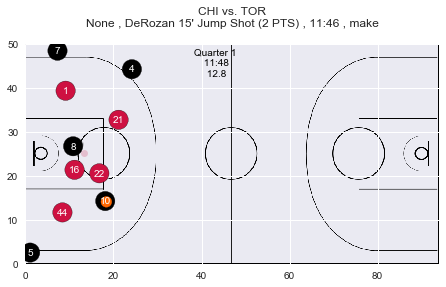

In [26]:
Plot = PlotGame(game_id, main_dir, game_dir)
# for i in range(plotn): 
Plot.load_moment2img(game_data, event_number=0, moment_number=0, return_img=True)

In [32]:
# single_game[0].shape

In [31]:
# # manual plot check
# plot_check(single_game, plt_ind=0)

#### Build graph and starts training for all single policies

In [33]:
sequence_length = 30
overlap = 15
batch_size = 32
train_all_single_policies(single_game, batch_size, sequence_length, overlap, models_path)

Wroking on policy 0
Horizon 0 ==========
Epoch 0    | loss: 617.54   | time took: 2.12s | validation loss: 659.24  
Epoch 100  | loss: 14.65    | time took: 1.45s | validation loss: 21.14   
Epoch 200  | loss: 11.46    | time took: 1.22s | validation loss: 14.55   
Epoch 300  | loss: 10.39    | time took: 1.13s | validation loss: 14.77   
Epoch 400  | loss: 9.39     | time took: 1.27s | validation loss: 14.25   
Epoch 500  | loss: 8.56     | time took: 1.23s | validation loss: 12.55   
Epoch 600  | loss: 8.08     | time took: 1.19s | validation loss: 12.66   
Epoch 700  | loss: 7.84     | time took: 1.09s | validation loss: 13.74   
Epoch 800  | loss: 7.02     | time took: 1.11s | validation loss: 12.50   
Epoch 900  | loss: 7.02     | time took: 1.17s | validation loss: 13.03   
Total time took: 0.32hrs
Horizon 2 ==========
Epoch 0    | loss: 21.32    | time took: 1.26s | validation loss: 25.24   
Epoch 100  | loss: 10.09    | time took: 1.22s | validation loss: 18.75   
Epoch 200  | 

KeyboardInterrupt: 

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning
    - from each sample to next sample theres not much change, subsample them 

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 